# Programming Exercise 8: Anomaly Detection and Recommender System
In this exercise, you will implement the anomaly detection algorithm and
apply it to detect failing servers on a network. In the second part, you will
use collaborative filtering to build a recommender system for movies.

In [1]:
# Scientific and vector computation for python
import numpy as np

# Import regular expressions process emails
import re

# Plotting library
import matplotlib.pyplot as plt

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# library written for this exercise providing additional functions
import utils

# tells matplotlib to embed plots with the notebook
%matplotlib inline

## 1 Anomaly Detection
In this exercise, you will implement an anomaly detection algorithm to detect
anomalous behavior in server computers. The features measure the throughput
(mb/s) and latency (ms) of response of each server. While your servers were
operating, you collected $m = 307$ examples of how they were behaving, and thus
have an unlabeled dataset $\{x^{(1)}, \dots, x^{(m)}\}$. You suspect that the
vast majority of these examples are “normal” (non-anomalous) examples of the
servers operating normally, but there might also be some examples of servers
acting anomalously within this dataset.

You will use a Gaussian model to detect anomalous examples in your dataset. You
will first start on a 2D dataset that will allow you to visualize what the
algorithm is doing. On that dataset you will fit a Gaussian distribution and
then find values that have very low probability and hence can be considered
anomalies. After that, you will apply the anomaly detection algorithm to a
larger dataset with many dimensions.

We start this exercise by using a small dataset that is easy to visualize. Our
example case consists of two network server statistics across several machines:
the latency and throughput of each machine.

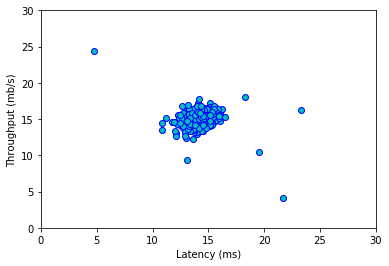

In [2]:
# The following command loads the dataset
data = loadmat('ex8data1.mat')
X, Xval, yval = data['X'], data['Xval'], data['yval'][:, 0]

# Visualize the example dataset
plt.plot(X[:, 0], X[:, 1], 'co', ms=6, mec='b', mew=1)
plt.axis([0, 30, 0, 30])
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
pass

### 1.1 Gaussian distribution
To perform anomaly detection, you will first need to fit a model to the data's
distribution. Given a training set $\{x^{(1)}, \dots, x^{(m)} \}$ (where
$x^{(i)} \in \mathbb{R}^n$ ), you want to estimate the Gaussian distribution
for each of the features $x_i$ . For each feature $i = 1, \dots ,n$, you need to
find parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the $i^{\text{th}}$
dimension $\{ x_i^{(1)}, \dots, x_i^{(m)} \}$ (the $i^{\text{th}}$ dimension of
each example).

The Gaussian distribution is given by

$$ p\left( x; \mu, \sigma^2 \right) = \frac{1}{\sqrt{2\pi}\sigma} e^{-\frac{\left(x-\mu\right)^2}{2\sigma^2}},$$

where $\mu$ is the mean and $\sigma^2$ is the variance.

### 1.2 Estimating parameters for a Gaussian
You can estimate the parameters $\left( \mu_i, \sigma_i^2 \right)$, of the
$i^{\text{th}}$ feature by using the following equations. To estimate the mean,
you will use:

$$ \mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)},$$

and for the variance you will use:

$$ \sigma_i^2 = \frac{1}{m} \sum_{j=1}^m \left( x_i^{(j)} - \mu_i \right)^2.$$

Your task is to complete the code in the function `estimateGaussian`. This
function takes as input the data matrix $X$ and should output an $n$-dimension
vector `mu` that holds the mean for each of the $n$ features and another
$n$-dimension vector `sigma2` that holds the variances of each of the features.
You can implement this using a `for`-loop over every feature and every training
example (though a vectorized implementation might be more efficient; feel free
to use a vectorized implementation if you prefer).

In [3]:
def estimateGaussian(X):
    """
    This function estimates the parameters of a Gaussian distribution using a
    provided dataset.

    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n) with each n-dimensional data point in
        one row, and each total of m data points.

    Returns
    -------
    mu : array_like
        A vector of shape (n,) containing the means of each dimension.

    sigma2 : array_like
        A vector of shape (n,) containing the computed variances of each dimension.
    """
    # Useful variables
    m, n = X.shape

    mu = (1 / m) * np.sum(X, axis=0)
    sigma2 = (1 / m) * np.sum((X - mu)**2, axis=0)

    return mu, sigma2

Once you have completed the code in `estimateGaussian`, the next cell will
visualize the contours of the fitted Gaussian distribution.

To do the visualization of the Gaussian fit, we first estimate the parameters
of our assumed Gaussian distribution, then compute the probabilities for each
of the points and then visualize both the overall distribution and where each
of the points falls in terms of that distribution.

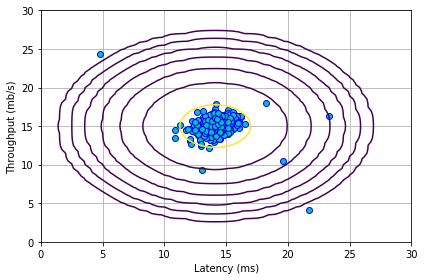

In [4]:
# Estimate mu and sigma2
mu, sigma2 = estimateGaussian(X)

# Returns the density of the multivariate normal at each data point (row) of X
p = utils.multivariateGaussian(X, mu, sigma2)

# Visualize the fit
utils.visualizeFit(X, mu, sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.tight_layout()
pass

### 1.3 Selecting the threshold $\varepsilon$
Now that you have estimated the Gaussian parameters, you can investigate which
examples have a very high probability given this distribution and which
examples have a very low probability. The low probability examples are more
likely to be the anomalies in our dataset. One way to determine which examples
are anomalies is to select a threshold based on a cross validation set. In this
part of the exercise, you will implement an algorithm to select the threshold
$\varepsilon$ using the $F_1$ score on a cross validation set.

You should now complete the code for the function `selectThreshold`. For this,
we will use a cross validation set
$\{ (x_{cv}^{(1)}, y_{cv}^{(1)}), \dots, (x_{cv}^{(m_{cv})}, y_{cv}^{(m_{cv})})\}$,
where the label $y = 1$ corresponds to an anomalous example, and $y = 0$
corresponds to a normal example. For each cross validation example, we will
compute $p\left( x_{cv}^{(i)}\right)$. The vector of all of these
probabilities $p\left( x_{cv}^{(1)}\right), \dots, p\left( x_{cv}^{(m_{cv})}\right)$
is passed to `selectThreshold` in the vector `pval`. The corresponding labels
$y_{cv}^{(1)} , \dots , y_{cv}^{(m_{cv})}$ are passed to the same function in
the vector `yval`.

The function `selectThreshold` should return two values; the first is the
selected threshold $\varepsilon$. If an example $x$ has a low probability
$p(x) < \varepsilon$, then it is considered to be an anomaly. The function
should also return the $F_1$ score, which tells you how well you are doing on
finding the ground truth anomalies given a certain threshold. For many
different values of $\varepsilon$, you will compute the resulting $F_1$ score
by computing how many examples the current threshold classifies correctly and
incorrectly.

The $F_1$ score is computed using precision ($prec$) and recall ($rec$):

$$ F_1 = \frac{2 \cdot prec \cdot rec}{prec + rec}, $$

You compute precision and recall by:

$$ prec = \frac{tp}{tp + fp}  $$
$$ rec = \frac{tp}{tp + fn} $$

where:
- $tp$ is the number of true positives: the ground truth label says it’s an
anomaly and our algorithm correctly classified it as an anomaly.

- $fp$ is the number of false positives: the ground truth label says it’s not
an anomaly, but our algorithm incorrectly classified it as an anomaly.

- $fn$ is the number of false negatives: the ground truth label says it’s an
anomaly, but our algorithm incorrectly classified it as not being anomalous.

In the provided code `selectThreshold`, there is already a loop that will try
many different values of $\varepsilon$ and select the best $\varepsilon$ based
on the $F_1$ score. You should now complete the code in `selectThreshold`. You
can implement the computation of the $F_1$ score using a `for`-loop over all
the cross validation examples (to compute the values $tp$, $fp$, $fn$). You
should see a value for `epsilon` of about 8.99e-05.

In [5]:
def selectThreshold(yval, pval):
    """
    Find the best threshold (epsilon) to use for selecting outliers based
    on the results from a validation set and the ground truth.

    Parameters
    ----------
    yval : array_like
        The validation dataset of shape (m x n) where m is the number
        of examples an n is the number of dimensions(features).

    pval : array_like
        The ground truth labels of shape (m, ).

    Returns
    -------
    bestEpsilon : array_like
        A vector of shape (n,) corresponding to the threshold value.

    bestF1 : float
        The value for the best F1 score.
    """
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0

    for epsilon in np.linspace(1.01 * min(pval), max(pval), 1000):
        predictions = (pval < epsilon)
        tp = np.sum((predictions == yval) & (yval == 1))
        fp = np.sum((predictions == 1) & (yval == 0))
        fn = np.sum((predictions == 0) & (yval == 1))

        prec = tp / (tp + fp)
        rec = tp / (tp + fn)

        F1 = 2 * prec * rec / (prec + rec)

        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon

    return bestEpsilon, bestF1

Once you have completed the code in `selectThreshold`, the next cell will run
your anomaly detection code and circle the anomalies in the plot.

Best epsilon found using cross-validation: 8.9999e-05
(This value should be about 8.99e-05)
Best F1 score on cross validation set: 0.875000
(This value should be about 0.875000)


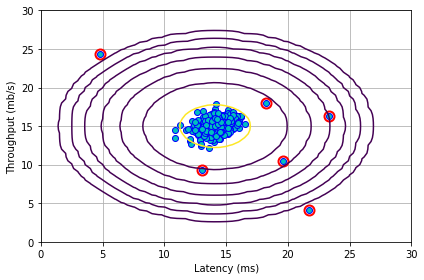

In [6]:
pval = utils.multivariateGaussian(Xval, mu, sigma2)

epsilon, F1 = selectThreshold(yval, pval)
print('Best epsilon found using cross-validation: %.4e' % epsilon)
print('(This value should be about 8.99e-05)')
print('Best F1 score on cross validation set: %f' % F1)
print('(This value should be about 0.875000)')

# Find the outliers in the training set and plot
outliers = p < epsilon

# Visualize the fit
utils.visualizeFit(X, mu, sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.tight_layout()

# Draw a red circle around those outliers
plt.plot(X[outliers, 0], X[outliers, 1], 'ro', ms=10, mfc='None', mew=2)
pass

### 1.4 High dimensional dataset
The next cell will run the anomaly detection algorithm you implemented on a
more realistic and much harder dataset. In this dataset, each example is
described by 11 features, capturing many more properties of your compute servers,
but only some features indicate whether a point is an outlier. The script will
use your code to estimate the Gaussian parameters ($\mu_i$ and $\sigma_i^2$),
evaluate the probabilities for both the training data `X` from which you
estimated the Gaussian parameters, and do so for the the cross-validation set
`Xval`. Finally, it will use `selectThreshold` to find the best threshold
$\varepsilon$. You should see a value epsilon of about 1.38e-18, and 117
anomalies found.

In [7]:
# Load the second dataset.
# You should now have the variables X, Xval, yval in your environment
data = loadmat('ex8data2.mat')
X, Xval, yval = data['X'], data['Xval'], data['yval'][:, 0]

# Apply the same steps tp the larger dataset
mu, sigma2 = estimateGaussian(X)

# Training set
p = utils.multivariateGaussian(X, mu, sigma2)

# Cross-validation set
pval = utils.multivariateGaussian(Xval, mu, sigma2)

# Find the best threshold
epsilon, F1 = selectThreshold(yval, pval)

print('Best epsilon found using cross-validation: %.4e' % epsilon)
print('(This value should be about 1.38e-18)')
print('Best F1 score on cross validation set: %f' % F1)
print('(This value should be about 0.615385)')
print('\nOutliers found: %d' % np.sum(p < epsilon))

Best epsilon found using cross-validation: 1.3786e-18
(This value should be about 1.38e-18)
Best F1 score on cross validation set: 0.615385
(This value should be about 0.615385)

Outliers found: 117


## 2 Recommender Systems
In this part of the exercise, you will implement the collaborative filtering
learning algorithm and apply it to a dataset of movie ratings
([MovieLens 100k Dataset](https://grouplens.org/datasets/movielens/) from
GroupLens Research). This dataset consists of ratings on a scale of 1 to 5. The
dataset has $n_u = 943$ users, and $n_m = 1682$ movies.

In the next parts of this exercise, you will implement the function
`cofiCostFunc` that computes the collaborative filtering objective function
and gradient. After implementing the cost function and gradient, you will use
`scipy.optimize.minimize` to learn the parameters for collaborative filtering.

### 2.1 Movie ratings dataset
The next cell will load the dataset `ex8_movies.mat`, providing the variables
`Y` and `R`. The matrix `Y` (a $\text{num_movies} \times \text{num_users}$
matrix) stores the ratings $y^{(i,j)}$ (from 1 to 5). The matrix `R` is an
binary-valued indicator matrix, where $R(i, j) = 1$ if user $j$ gave a rating
to movie $i$, and $R(i, j) = 0$ otherwise. The objective of collaborative
filtering is to predict movie ratings for the movies that users have not yet
rated, that is, the entries with $R(i, j) = 0$. This will allow us to
recommend the movies with the highest predicted ratings to the user.

To help you understand the matrix `Y`, the following cell will compute the
average movie rating for the first movie (Toy Story) and print its average
rating.

Average rating for movie 1 (Toy Story): 4.52 / 5


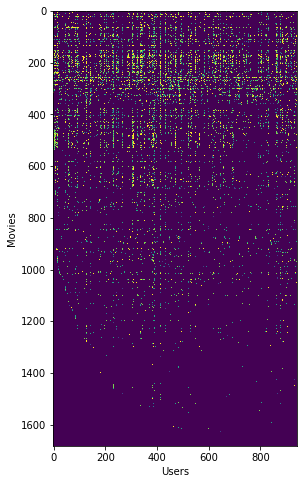

In [8]:
# Load data
data = loadmat('ex8_movies.mat')
Y, R = data['Y'], data['R']

# Y is a 1682x943 matrix, contains ratings (1-5) of 1682 movies on 943 users
# R is a 1682x943 matrix, where R(i,j)=1 if and only user j gave a rating to movie i

# From the matrix, we cam compute the statistics like avarage rating
print('Average rating for movie 1 (Toy Story): %.2f / 5' % np.mean(Y[0, R[0, :]]))

# We can "visualize" the ratings matrix by plotting it with `imshow`
plt.figure(figsize=(8, 8))
plt.imshow(Y)
plt.xlabel('Users')
plt.ylabel('Movies')
plt.grid(False)
pass

Throughout this part of the exercise, you will also be working with the
matrices, `X` and `Theta`:

$$ \text{X} =  \begin{bmatrix} - \left(x^{(1)}\right)^T - \\ - \left(x^{(2)}\right)^T - \\ \vdots \\ - \left(x^{(n_m)}\right)^T - \\ \end{bmatrix}, \quad \text{Theta} =  \begin{bmatrix} - \left(\theta^{(1)}\right)^T - \\ - \left(\theta^{(2)}\right)^T - \\ \vdots \\ - \left(\theta^{(n_u)}\right)^T - \\ \end{bmatrix}.$$

The $i^{\text{th}}$ row of `X` corresponds to the feature vector $x^{(i)}$ for
the $i^{\text{th}}$ movie, and the $j^{\text{th}}$ row of `Theta` corresponds
to one parameter vector $\theta^{(j)}$, for the $j^{\text{th}}$ user. Both
$x^{(i)}$ and $\theta^{(j)}$ are $n$-dimensional vectors. For the purposes of
this exercise, you will use $n = 100$, and therefore,
$x^{(i)} \in \mathbb{R}^{100}$ and $\theta^{(j)} \in \mathbb{R}^{100}$.
Correspondingly, `X` is a $n_m \times 100$ matrix and `Theta` is a
$n_u \times 100$ matrix.

### 2.2 Collaborative filtering learning algorithm
Now, you will start implementing the collaborative filtering learning
algorithm. You will start by implementing the cost function (without
regularization).

The collaborative filtering algorithm in the setting of movie recommendations
considers a set of $n$-dimensional parameter vectors
$x^{(1)}, \dots, x^{(n_m)}$ and $\theta^{(1)} , \dots, \theta^{(n_u)}$, where
the model predicts the rating for movie $i$ by user $j$ as
$y^{(i,j)} = \left( \theta^{(j)} \right)^T x^{(i)}$. Given a dataset that
consists of a set of ratings produced by some users on some movies, you wish
to learn the parameter vectors
$x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots, \theta^{(n_u)}$ that produce
the best fit (minimizes the squared error).

You will complete the code in `cofiCostFunc` to compute the cost function and
gradient for collaborative filtering. Note that the parameters to the
function (i.e., the values that you are trying to learn) are `X` and `Theta`.
In order to use an off-the-shelf minimizer such as `scipy's minimize` function,
the cost function has been set up to unroll the parameters into a single vector
called `params`. You had previously used the same vector unrolling method in
the neural networks programming exercise.

#### 2.2.1 Collaborative filtering cost function
The collaborative filtering cost function (without regularization) is given by

$$J(x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots,\theta^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right)^2$$

You should now modify the function `cofiCostFunc` to return this cost in the
variable `J`. Note that you should be accumulating the cost for user $j$ and
movie $i$ only if `R[i,j] = 1`.

In [9]:
def cofiCostFunc(params, Y, R, num_users, num_movies,
                      num_features, lambda_=0.0):
    """
    Collaborative filtering cost function.

    Parameters
    ----------
    params : array_like
        The parameters which will be optimized. This is a one
        dimensional vector of shape (num_movies x num_users, 1). It is the
        concatenation of the feature vectors X and parameters Theta.

    Y : array_like
        A matrix of shape (num_movies x num_users) of user ratings of movies.

    R : array_like
        A (num_movies x num_users) matrix, where R[i, j] = 1 if the
        i-th movie was rated by the j-th user.

    num_users : int
        Total number of users.

    num_movies : int
        Total number of movies.

    num_features : int
        Number of features to learn.

    lambda_ : float, optional
        The regularization coefficient.

    Returns
    -------
    J : float
        The value of the cost function at the given params.

    grad : array_like
        The gradient vector of the cost function at the given params.
        grad has a shape (num_movies x num_users, 1)
    """
    # Unfold the U and W matrices from params
    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    Theta = params[num_movies * num_features:].reshape(num_users, num_features)

    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)

    J = 0.5 * np.sum(np.square((np.dot(X, Theta.T) - Y) * R)) + \
        (lambda_ / 2) * np.sum(np.square(X)) + (lambda_ / 2) * np.sum(np.square(Theta))

    for i in range(R.shape[0]):
        idx = np.where(R[i, :] == 1)[0]
        Theta_temp = Theta[idx, :]
        Y_temp = Y[i, idx]
        X_grad[i, :] = np.dot(np.dot(X[i, :], Theta_temp.T) - Y_temp, Theta_temp) + lambda_ * X[i, :]

    for j in range(R.shape[1]):
        idx = np.where(R[:, j] == 1)[0]
        X_temp = X[idx, :]
        Y_temp = Y[idx, j]
        Theta_grad[j, :] = np.dot(np.dot(X_temp, Theta[j, :]) - Y_temp, X_temp) + lambda_ * Theta[j, :]

    grad = np.concatenate([X_grad.ravel(), Theta_grad.ravel()])

    return J, grad

After you have completed the function, the next cell will run your cost
function. To help you debug your cost function, we have included set of weights
that we trained on that. You should expect to see an output of 22.22.

In [10]:
# Load pre-trained weights (X, Theta, num_users, num_movies, num_features)
data = loadmat('ex8_movieParams.mat')
X, Theta, num_users, num_movies, num_features = data['X'], data['Theta'], \
    int(data['num_users']), int(data['num_movies']), int(data['num_features'])

# Reduce the data set size so that this runs faster
num_users = 4
num_movies = 5
num_features = 3

X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, 0:num_users]
R = R[:num_movies, 0:num_users]

# Evaluate cost function
J, _ = cofiCostFunc(np.concatenate([X.ravel(), Theta.ravel()]), Y, R,
                    num_users, num_movies, num_features)
print('Cost at loaded parameters: %.2f' % J)

Cost at loaded parameters: 22.22


#### 2.2.2 Collaborative filtering gradient
Now you should implement the gradient (without regularization). Specifically,
you should complete the code in `cofiCostFunc` to return the variables `X_grad`
and `Theta_grad`. Note that `X_grad` should be a matrix of the same size as `X`
and similarly, `Theta_grad` is a matrix of the same size as `Theta`. The
gradients of the cost function is given by:

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right) \theta_k^{(j)} $$$$ \frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)}- y^{(i,j)} \right) x_k^{(j)} $$

Note that the function returns the gradient for both sets of variables by
unrolling them into a single vector. After you have completed the code to
compute the gradients, the next cell run a gradient check (available in
`utils.checkCostFunction`) to numerically check the implementation of your
gradients (this is similar to the numerical check that you used in the neural
networks exercise. If your implementation is correct, you should find that
the analytical and numerical gradients match up closely.

(Go back to the function `cofiCostFunc` to update it.)

In [11]:
# Check gradients by running checkCostFunction
utils.checkCostFunction(cofiCostFunc)

[[-1.33161965e+00 -1.33161965e+00]
 [-2.92248530e+00 -2.92248530e+00]
 [-2.03789397e+00 -2.03789397e+00]
 [ 1.59748179e-01  1.59748179e-01]
 [-2.46883510e-03 -2.46883510e-03]
 [-7.20350864e-01 -7.20350864e-01]
 [ 2.07790853e+00  2.07790853e+00]
 [ 1.35069007e+00  1.35069007e+00]
 [ 2.16663909e+00  2.16663909e+00]
 [ 6.19320287e-01  6.19320287e-01]
 [-2.40178009e+00 -2.40178009e+00]
 [-3.96821617e+00 -3.96821617e+00]
 [-2.64695281e+00 -2.64695281e+00]
 [-3.59335638e+00 -3.59335638e+00]
 [-4.33043564e+00 -4.33043564e+00]
 [-1.80211701e+00 -1.80211701e+00]
 [-2.10986141e+00 -2.10986141e+00]
 [-3.30280302e+00 -3.30280302e+00]
 [ 1.57994188e+00  1.57994188e+00]
 [-1.35859458e+00 -1.35859458e+00]
 [-3.93287910e+00 -3.93287910e+00]
 [ 1.04769997e+00  1.04769997e+00]
 [-1.25301254e+00 -1.25301254e+00]
 [-2.09372324e+00 -2.09372324e+00]
 [-1.27509503e+00 -1.27509503e+00]
 [-3.79421459e+00 -3.79421459e+00]
 [-7.56830334e+00 -7.56830334e+00]]

The above two columns you get should be very similar.

#### 2.2.3 Regularized cost function
The cost function for collaborative filtering with regularization is given by

$$ J(x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots, \theta^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( \left( \theta^{(j)} \right)^T x^{(i)} - y^{(i,j)} \right)^2 +  \frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^{n} \left( \theta_k^{(j)} \right)^2  +  \frac{\lambda}{2} \sum_{i=1}^{n_m} \sum_{k=1}^n \left(x_k^{(i)} \right)^2 $$

You should now add regularization to your original computations of the cost
function, $J$. After you are done, the next cell will run your regularized
cost function, and you should expect to see a cost of about 31.34.

(Go back to the function `cofiCostFunc` to update it.)

In [12]:
# Evaluate cost function
J, _ = cofiCostFunc(np.concatenate([X.ravel(), Theta.ravel()]), Y, R,
                    num_users, num_movies, num_features, lambda_=1.5)
print('Cost at loaded parameters (lambda = 1.5): %.6f' % J)
print('             (This value should be about: 31.34)')

Cost at loaded parameters (lambda = 1.5): 31.344056
             (This value should be about: 31.34)


#### 2.2.4 Regularized gradient
Now that you have implemented the regularized cost function, you should
proceed to implement regularization for the gradient. You should add to your
implementation in `cofiCostFunc` to return the regularized gradient by adding
the contributions from the regularization terms. Note that the gradients for
the regularized cost function is given by:

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right) \theta_k^{(j)} + \lambda x_k^{(i)} $$$$ \frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)}- y^{(i,j)} \right) x_k^{(j)} + \lambda \theta_k^{(j)} $$

This means that you just need to add $\lambda x^{(i)}$ to the `X_grad[i,:]`
variable described earlier, and add $\lambda \theta^{(j)}$ to the
`Theta_grad[j, :]` variable described earlier.

(Go back to the function `cofiCostFunc` to update it.)

After you have completed the code to compute the gradients, the following
cell will run another gradient check (`utils.checkCostFunction`) to numerically
check the implementation of your gradients.

In [13]:
# Check gradients by running checkCostFunction
utils.checkCostFunction(cofiCostFunc, lambda_=1.5)

[[ -1.04271808  -1.04271808]
 [  1.72332796   1.72332796]
 [  1.2354923    1.2354923 ]
 [ -1.39102661  -1.39102661]
 [  3.28921543   3.28921543]
 [ -1.17115031  -1.17115031]
 [  5.0661312    5.0661312 ]
 [-15.00189716 -15.00189716]
 [ -0.06628407  -0.06628407]
 [  3.43929395   3.43929395]
 [-11.59810634 -11.59810634]
 [  2.76004869   2.76004869]
 [  4.19436262   4.19436262]
 [-11.83612963 -11.83612963]
 [  0.71819614   0.71819614]
 [ -2.0324774   -2.0324774 ]
 [ 16.3444819   16.3444819 ]
 [ -8.04137156  -8.04137156]
 [  0.08067695   0.08067695]
 [  1.49820117   1.49820117]
 [ -0.55847951  -0.55847951]
 [ -0.39318411  -0.39318411]
 [  5.536974     5.536974  ]
 [ -1.49628706  -1.49628706]
 [  1.58324897   1.58324897]
 [ -1.41566023  -1.41566023]
 [  0.5705733    0.5705733 ]]

The above two columns you get should be very similar.(Left-Your Numerical Gradient; Right-Analytical Gradient)
If your cost function implementation is correct, then the relative difference will be small (less than 1

### 2.3 Learning movie recommendations
After you have finished implementing the collaborative filtering cost function
and gradient, you can now start training your algorithm to make movie
recommendations for yourself. In the next cell, you can enter your own movie
preferences, so that later when the algorithm runs, you can get your own movie
recommendations! We have filled out some values according to our own preferences,
but you should change this according to your own tastes. The list of all movies
and their number in the dataset can be found listed in the file `movie_idx.txt`.

In [14]:
# Before we will train the collaborative filtering model, we will first add ratings
# that correspond to a new user that we just observed. This part of the code will
# also allow you to put in your own ratings for the movies in our dataset!
movieList = utils.loadMovieList()
n_m = len(movieList)

# Initialize my ratings
my_ratings = np.zeros(n_m)

# Check the file `movie_idx.txt` for id of each movie in our dataset
# For example, Toy Story (1995) has ID 1, so to rate it "4",
# you can set it according to you preference
my_ratings[0] = 4

# Or suppose did not enjoy Silence of the Lambs (1991), you can set
my_ratings[97] = 2

#  We have selected a few movies we liked / did not like and the ratings we
# gave are as follows:
my_ratings[6] = 3
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63] = 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

print('[Ratings of new user: THISTLEDOWN]')
print('{:<55}  {}'.format('Movie Name (Year)', 'Rating'))
print('{:<55}  {}'.format('-----------------', '------'))
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('{:<55}  {}'.format(movieList[i], str('⭐' * int(my_ratings[i]))))

[Ratings of new user: THISTLEDOWN]
Movie Name (Year)                                        Rating
-----------------                                        ------
Toy Story (1995)                                         ⭐⭐⭐⭐
Twelve Monkeys (1995)                                    ⭐⭐⭐
Usual Suspects, The (1995)                               ⭐⭐⭐⭐⭐
Outbreak (1995)                                          ⭐⭐⭐⭐
Shawshank Redemption, The (1994)                         ⭐⭐⭐⭐⭐
While You Were Sleeping (1995)                           ⭐⭐⭐
Forrest Gump (1994)                                      ⭐⭐⭐⭐⭐
Silence of the Lambs, The (1991)                         ⭐⭐
Alien (1979)                                             ⭐⭐⭐⭐
Die Hard 2 (1990)                                        ⭐⭐⭐⭐⭐
Sphere (1998)                                            ⭐⭐⭐⭐⭐


#### 2.3.1 Recommendations
After the additional ratings have been added to the dataset, the script will
proceed to train the collaborative filtering model. This will learn the
parameters `X` and `Theta`. To predict the rating of movie $i$ for user $j$,
you need to compute $(\theta^{(j)})^T x^{(i)} $. The next part of the script
computes the ratings for all the movies and users and displays the movies that
it recommends, according to ratings that were entered earlier in the script.
Note that you might obtain a different set of the predictions due to different
random initializations.

In [15]:
# Now, you will train collaborative filtering model on a movie rating dataset
# of 1682 movies and 943 users

# Load data
data = loadmat('ex8_movies.mat')
Y, R = data['Y'], data['R']

# Y is a 1682x943 matrix, containing ratings (1~5) of 1682 movies by 943 users
# R is a 1682x943 matrix, where R(i,j)=1 if and only user j gave a rating to movie i

# Add our own ratings to the data matrix
Y = np.hstack([my_ratings[:, None], Y])
R = np.hstack([(my_ratings > 0)[:, None], R])

# Normalize ratings
Ynorm, Ymean = utils.normalizeRatings(Y, R)

# Useful values
num_movies, num_users = Y.shape
num_features = 10

# Set initial parameters (Theta, K)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.concatenate([X.ravel(), Theta.ravel()])

# Set options for `scipy.optimize.minimize`
options = {'maxiter': 200}

# Set regularization
lambda_ = 10
res = optimize.minimize(lambda x: cofiCostFunc(x, Ynorm, R, num_users, num_movies,
                                               num_features, lambda_),
                        initial_parameters,
                        method='TNC',
                        jac=True,
                        options=options)
theta = res.x

# Unfold the returned theta back into U and W
X = theta[:num_movies * num_features].reshape(num_movies, num_features)
Theta = theta[num_movies * num_features:].reshape(num_users, num_features)

print('Recommender system learning completed.')

Recommender system learning completed.


After training the model, you can now make recommendations by computing the predictions matrix.

In [16]:
p = np.dot(X, Theta.T)
my_predictions = p[:, 0] + Ymean

movieList = utils.loadMovieList()

ix = np.argsort(my_predictions)[::-1]
print('[Top recommendations for user: THISTLEDOWN]')
print('{:<55}  {}'.format('Movie Name (Year)', 'Predicting rating'))
print('{:<55}  {}'.format('-----------------', '-----------------'))
for i in range(10):
    j = ix[i]
    print('{:<55}  {}'.format(movieList[j], str('⭐' * int(my_predictions[j]))))

[Top recommendations for user: THISTLEDOWN]
Movie Name (Year)                                        Predicting rating
-----------------                                        -----------------
Prefontaine (1997)                                       ⭐⭐⭐⭐⭐
Entertaining Angels: The Dorothy Day Story (1996)        ⭐⭐⭐⭐⭐
Santa with Muscles (1996)                                ⭐⭐⭐⭐⭐
Marlene Dietrich: Shadow and Light (1996)                ⭐⭐⭐⭐⭐
They Made Me a Criminal (1939)                           ⭐⭐⭐⭐⭐
Great Day in Harlem, A (1994)                            ⭐⭐⭐⭐
Someone Else's America (1995)                            ⭐⭐⭐⭐
Star Kid (1997)                                          ⭐⭐⭐⭐
Aiqing wansui (1994)                                     ⭐⭐⭐⭐
Saint of Fort Washington, The (1993)                     ⭐⭐⭐⭐
